### Visualizing TFIDF Models of the Arab Observer Summer 1960 and February 1961

This notebook contains the required code to make visualizations to analyze TFIDF models of the Arab Observer

In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import ast
from scipy.stats import variation

In [12]:
# Read in required datasets
# Full Corpus
full_corpus_df = pd.read_json('./data/arab_observer_corpus_cleaned.json', orient='records')

full_corpus_url = './data/arab_observer_corpus_cleaned.json'
full_corpus_df['datetime'] = pd.to_datetime(full_corpus_df['date'], format='%Y-%B-%d', errors='coerce')
full_corpus_dates = full_corpus_df.date.unique().tolist()

# Congo Corpus
congo_corpus_df = pd.read_json('./data/arab_observer_congo_cleaned.json', orient='records')

congo_corpus_url = './data/arab_observer_congo_cleaned.json'
congo_corpus_df['datetime'] = pd.to_datetime(congo_corpus_df['date'], format='%Y-%B-%d', errors='coerce')
congo_corpus_dates = congo_corpus_df.date.unique().tolist()

Function for comparing TFIDF models

In [50]:
def normalize_texts(original_df):
    original_df_texts = ' '.join(original_df.cleaned_spacy_text)
    original_df_texts = original_df_texts.split(' ')
    val = round(len(original_df_texts) / len(original_df))
    text = []
    for i in range(0, len(original_df_texts), val):
        chunk = ' '.join(original_df_texts[i:i + val])
#         print(chunk)
        if i + val + val > len(original_df_texts):
            chunk = ' '.join(original_df_texts[i:])
            text.append(chunk)
            break
        text.append(chunk)
    split_original_df = pd.DataFrame({'cleaned_spacy_text': text})
#     print(split_original_df)
    split_original_df['cleaned_spacy_counts'] = split_original_df.cleaned_spacy_text.str.split().str.len()
    split_original_df['page_number'] = split_original_df.index
    return split_original_df

In [49]:
def create_tfidf_model(df, ngr, model_identifier, max_terms, maxdf=1.0):
    
    vectorizer = TfidfVectorizer(ngram_range=ngr, max_df=maxdf)
    docs = vectorizer.fit_transform(df.cleaned_spacy_text.values.astype('U'))
    features = vectorizer.get_feature_names()
    count = np.squeeze(np.asarray(docs.sum(axis=0)))
    sorted_count = count.argsort()[::-1]
    dist_df =pd.DataFrame({'freq': count, 'term':np.array(features)})
    dist_df['type'] = model_identifier
    dist_df['freqz'] = dist_df[['freq']].apply(lambda x: (x-x.min())/(x.max()-x.min())+ 0.000001)
    dist_df.sort_values(by=['freqz'], inplace=True, ascending=False)
    df2 = pd.DataFrame(docs.toarray(), columns = features)
    df3 = df2.T
    df3['term'] = df3.index
    df3.reset_index(inplace=True, drop=True)
    df_melted = df3.melt('term', value_name='value', var_name='page_number')

    df_merged = dist_df.merge(df_melted, on='term', how='inner')
    df_terms = df_merged.copy()
    df_terms = df_terms.drop_duplicates('term')
    
    return df_terms[0:max_terms]

In [60]:
def shape_corpus(df, type1, type2):
    df['corpus_type'] = ''
    df.corpus_type[(df.type_x.isna() == False) & (df.type_y.isna() == True)] =  type1
    df.corpus_type[(df.type_x.isna() == True) & (df.type_y.isna() == False)] = type2
    df.corpus_type[(df.type_x.isna() == False) & (df.type_y.isna() == False)] = 'common both corpuses'
    first_df = df.loc[df.type_x == type1]
    second_df = df.loc[df.type_y == type2]
    dist_both = df.loc[df.corpus_type == 'common both corpuses']
    return first_df, second_df, dist_both

In [52]:
def get_counts_full(term):
    rows = norm_summer_congo.loc[norm_summer_congo.cleaned_spacy_text.str.contains(term) == True].copy()
    counts = rows.cleaned_spacy_text.str.count(term).sum()
    return counts
def get_values(processed_both):
    processed_both['abs_change'] = processed_both.freqz_x - processed_both.freqz_y
    processed_both.abs_change = processed_both.abs_change.abs()
    processed_both['counts'] = processed_both.term.apply(get_counts_full)
    return processed_both

In [53]:
def plot_both_models(processed_both, main_title, title_y, title_x):

    sns.set_style("white")
    %matplotlib inline
    # plt.rcParams['figure.figsize']=(1000,1000)
    g = sns.lmplot(x='freqz_y', y='freqz_x', data=processed_both, ci=90, scatter_kws={'s':processed_both.counts,'alpha':0.7, }, line_kws={'color':'grey', 'alpha':0.5});
    g.fig.set_size_inches(15,15)
    axes = g.axes.flatten()
    axes[0].set_title(main_title)
    axes[0].set_ylabel(title_y)
    axes[0].set_xlabel(title_x)

    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.01, point['y'], str(point['val']))

    label_point(processed_both.freqz_y, processed_both.freqz_x, processed_both.term, plt.gca())
return plt.gca()

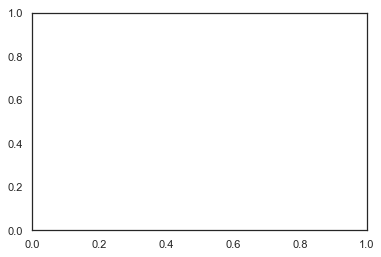

In [54]:
def compare_model_lists(full_corpus, subset_corpus, title1, title2):
    fc = alt.Chart(full_corpus).mark_bar().encode(
        x=alt.X('freq_y:Q', axis=alt.Axis(title='TF-IDF weight')),
        y=alt.Y(
            'term:N',
             sort=alt.EncodingSortField(
                field="freq_y",  # The field to use for the sort
                op="sum",  # The operation to run on the field prior to sorting
                order="descending"  # The order to sort in
            )
        ),
        color='corpus_type:N'

    ).properties(title=title1, height=800, width=200)


    sc = alt.Chart(subset_corpus).mark_bar().encode(
        x=alt.X('freq_x:Q', axis=alt.Axis(title='TF-IDF weight')),
        y=alt.Y(
            'term:N',
             sort=alt.EncodingSortField(
                field="freq_x",  # The field to use for the sort
                op="sum",  # The operation to run on the field prior to sorting
                order="descending"  # The order to sort in
            )
        ),
        color=alt.Color('corpus_type:N')

    ).properties(title=title2, height=800, width=200)
    alt.themes.enable('opaque')
    charts = alt.hconcat(fc | sc ).configure_axisX(labelAngle=0, labels=False)
    return charts

In [66]:
df_summer = full_corpus_df.loc[full_corpus_df.datetime < '1960-09-01']
var_summer = variation(df_summer.cleaned_spacy_counts)
skew_summer = df_summer.cleaned_spacy_counts.skew()
kurtosis_summer = df_summer.cleaned_spacy_counts.kurtosis()
df_summer = df_summer.dropna(subset=['cleaned_spacy_text'])

norm_summer = normalize_texts(df_summer)

tfidf_summer = create_tfidf_model(df_summer, (1,2), 'full_summer_1960', 50)

df_summer_congo = congo_corpus_df.loc[congo_corpus_df.datetime < '1960-09-01']

norm_summer_congo = normalize_texts(df_summer_congo)
tfidf_summer_congo = create_tfidf_model(df_summer_congo, (1,2), 'congo_summer_1960', 50)

summer_congo = tfidf_summer_congo.merge(tfidf_summer, on=['term'], how='outer')

processed_congo, processed_summer, processed_both = shape_corpus(summer_congo, 'congo_summer_1960', 'full_summer_1960')
processed_both = get_values(processed_both)

In [70]:
processed_congo_url = './data/processed_congo_summer1960.json'
processed_congo.to_json(processed_congo_url, orient='records')
processed_summer_url = './data/processed_summer1960.json'
processed_summer.to_json(processed_summer_url, orient='records')

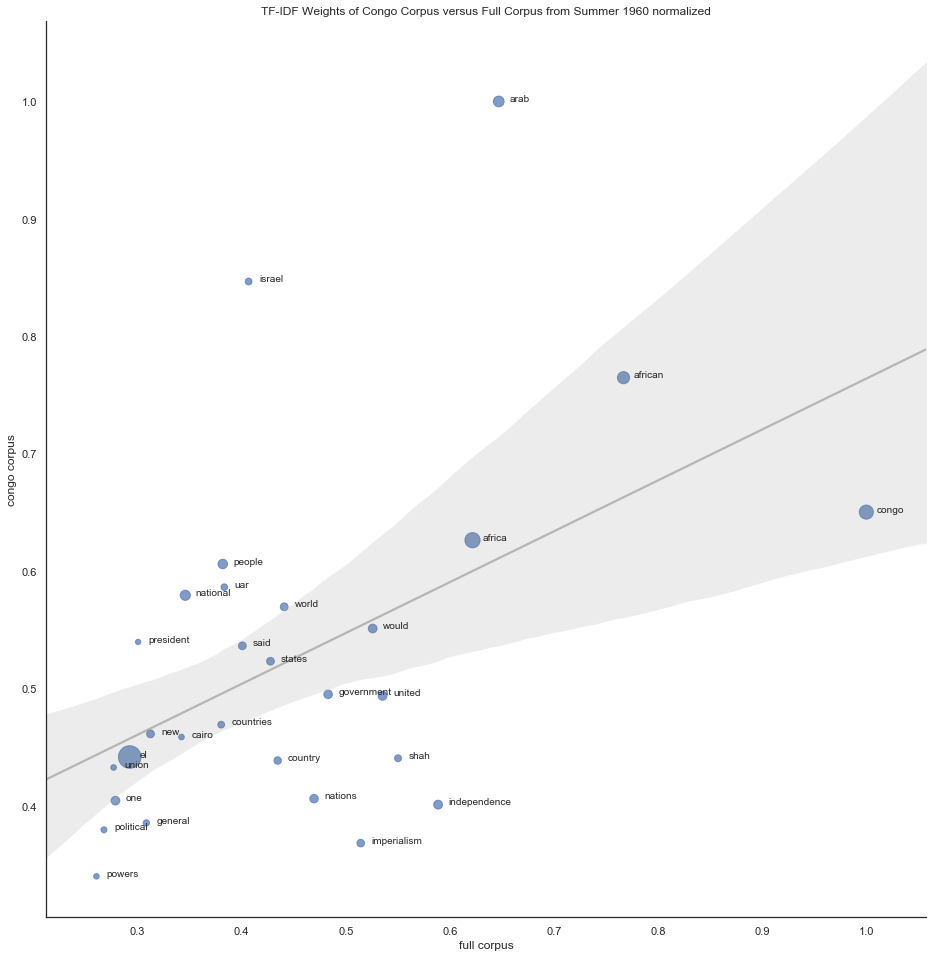

In [56]:
summer_congo_1960 = plot_both_models(processed_both, 'TF-IDF Weights of Congo Corpus versus Full Corpus from Summer 1960 normalized', 'congo corpus', 'full corpus')
summer_congo_1960

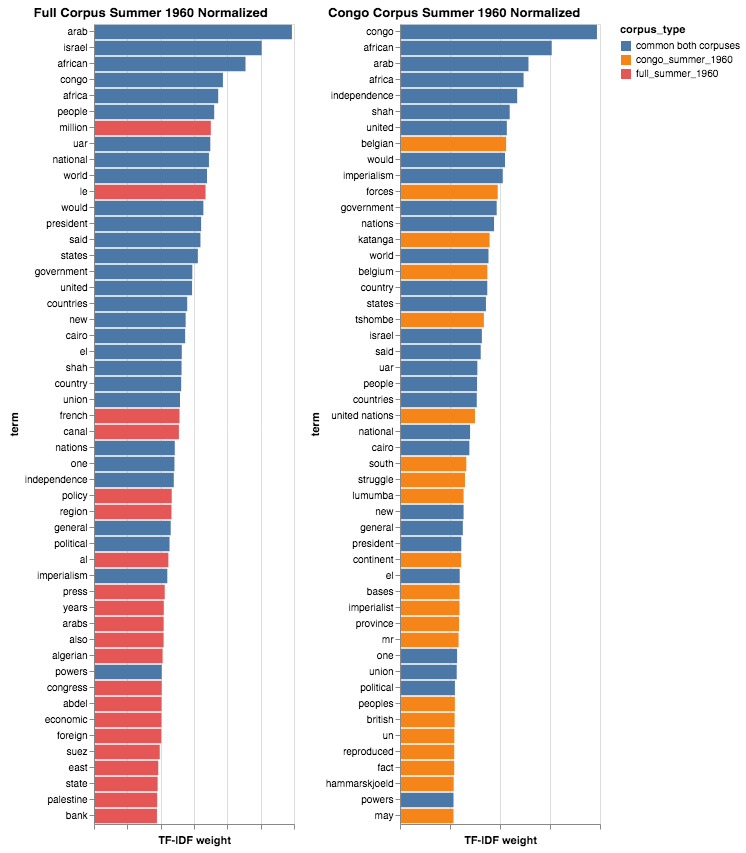

In [71]:
lists_1960 = compare_model_lists(processed_summer_url, processed_congo_url, 'Full Corpus Summer 1960 Normalized', 'Congo Corpus Summer 1960 Normalized')
lists_1960

Visualization of TF-IDF model of pages that mention Congo compared to full issues February 1961 normalized

In [78]:
df_feb = full_corpus_df.loc[full_corpus_df.string_date.str.contains('1961-February')]
var_feb = variation(df_feb.cleaned_spacy_counts)
skew_feb = df_feb.cleaned_spacy_counts.skew()
kurtosis_feb = df_feb.cleaned_spacy_counts.kurtosis()
norm_feb = normalize_texts(df_feb)
tfidf_feb = create_tfidf_model(df_feb, (1,2), 'full_feb_1961', 50)

df_feb_congo = congo_corpus_df.loc[congo_corpus_df.string_date.str.contains('1961-February')]
norm_feb_congo = normalize_texts(df_feb_congo)
tfidf_feb_congo = create_tfidf_model(df_feb_congo, (1,2), 'congo_feb_1961', 50)

feb_congo = tfidf_feb_congo.merge(tfidf_feb, on=['term'], how='outer')
processed_feb_congo, processed_feb, processed_feb_both = shape_corpus(feb_congo, 'congo_feb_1961', 'full_feb_1961')
processed_feb_both = get_values(processed_feb_both)

In [79]:
processed_feb_congo_url = './data/processed_congo_feb1961.json'
processed_feb_congo.to_json(processed_feb_congo_url, orient='records')
processed_feb_url = './data/processed_feb1961.json'
processed_feb.to_json(processed_feb_url, orient='records')

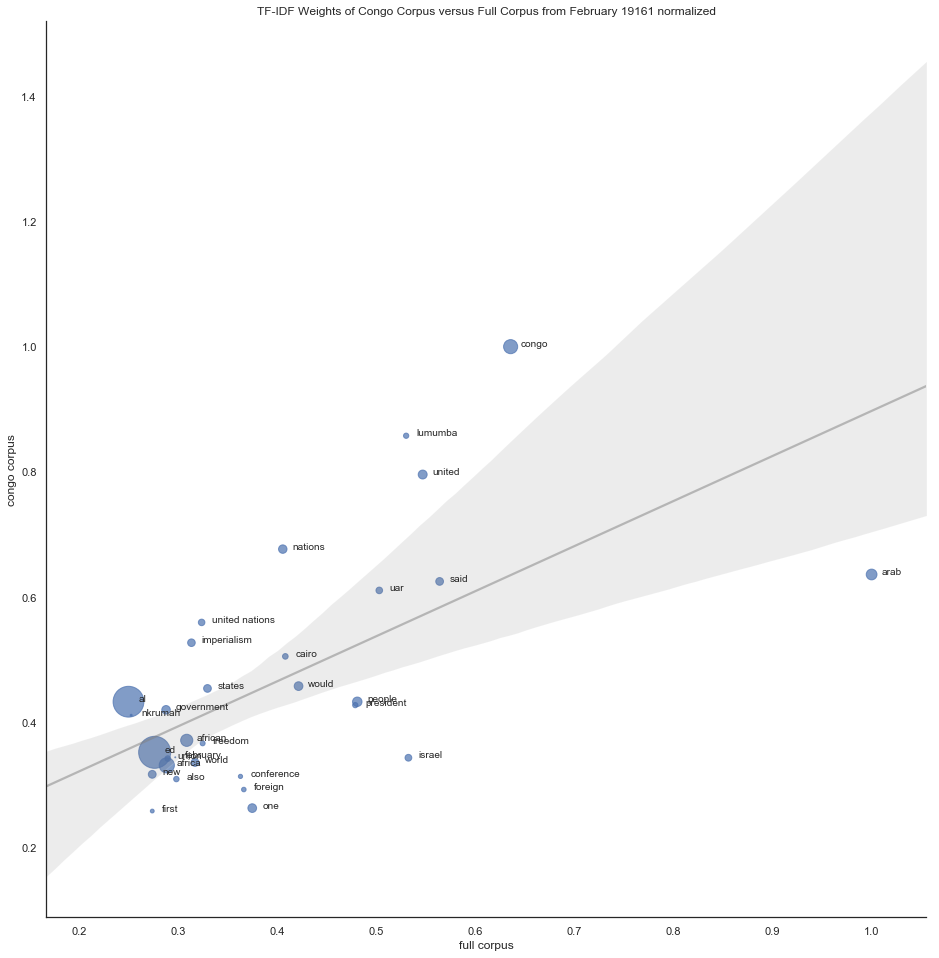

In [80]:
feb_congo_1961 = plot_both_models(processed_feb_both, 'TF-IDF Weights of Congo Corpus versus Full Corpus from February 19161 normalized', 'congo corpus', 'full corpus')
# summer_congo_1960

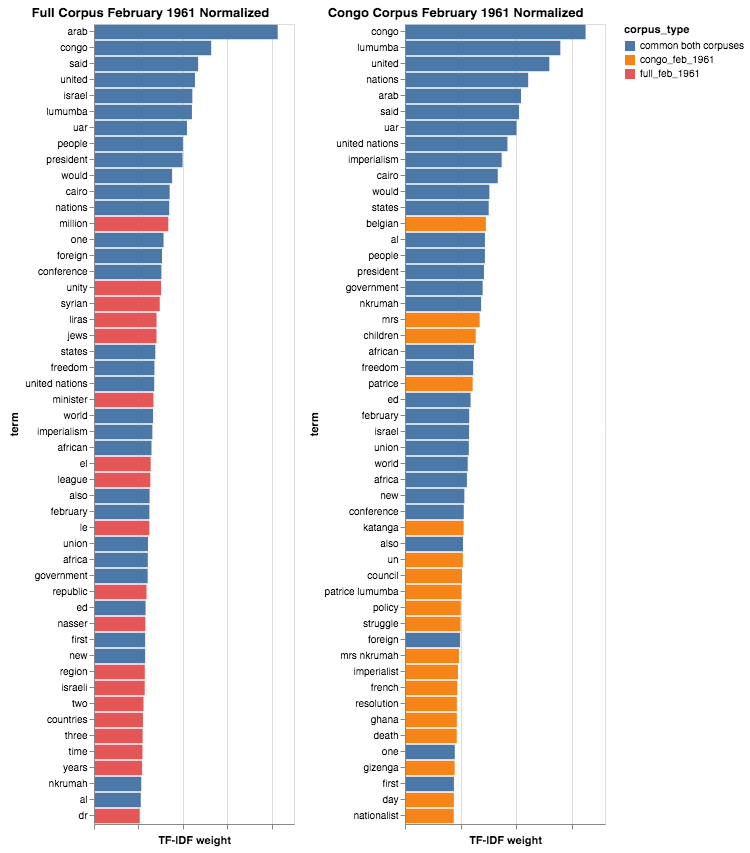

In [81]:
lists_1961 = compare_model_lists(processed_feb_url, processed_feb_congo_url, 'Full Corpus February 1961 Normalized', 'Congo Corpus February 1961 Normalized')
lists_1961